In [124]:
#importing relevant packages for this forecast
from prophet import Prophet
import pandas as pd
import os
from datetime import date as dt

In [111]:
revenue = pd.read_csv(f'{os.getcwd()}/values-2018-2021.csv', sep = ';', encoding = 'latin-1')
revenue.head()

In [125]:
#defining a set of columns for treatment
float_columns = revenue.select_dtypes(include = 'float64').columns

revenue[float_columns] = revenue[float_columns].round(2)
revenue['DT_PAGAMENTO'] = revenue['DT_PAGAMENTO'].astype('datetime64')
revenue['DT_PAGAMENTO'] = revenue['DT_PAGAMENTO'].dt.strftime('%Y-%m-%d')
revenue

,DT_PAGAMENTO,VL_PAGO,VL_PARCELAS
0,2018-01-02,1416.59,1416.59
1,2018-05-02,2131.73,2131.73
2,2018-06-02,761.78,761.78
3,2018-06-02,4023.79,4023.79
4,2018-07-02,14.40,14.40
...,...,...,...
15425,2021-09-15,2202.37,2202.37
15426,2021-09-15,808.00,45.00
15427,2021-09-15,1160.66,1194.50
15428,2021-09-15,1842385.00,1834095.00


In [126]:
#selecting the relevant columns for fiting the model and renaming it to the Prophet pattern
df = revenue[['DT_PAGAMENTO','VL_PAGO']]
df = df.rename(columns = {'DT_PAGAMENTO': 'ds','VL_PAGO' : 'y'})
df

,ds,y
0,2018-01-02,1416.59
1,2018-05-02,2131.73
2,2018-06-02,761.78
3,2018-06-02,4023.79
4,2018-07-02,14.40
...,...,...
15425,2021-09-15,2202.37
15426,2021-09-15,808.00
15427,2021-09-15,1160.66
15428,2021-09-15,1842385.00


In [117]:
#calling the model and fitting it

model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.86686
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       62119.6   1.99005e-05        1100.6           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       62120.8   4.26914e-05       989.486           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       62121.2   5.25291e-05       237.009      0.8603      0.8603      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       62121.6   3.42588e-05       331.684           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       62121.8   8.71474e-06       174.697      0.6918      0.6918      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

  62121.9   4.17447e-05       390.153           1           1      675   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     686         62122    3.0935e-06       513.895   3.653e-09       0.001      828  LS failed, Hessian reset 
     699         62122   7.10078e-06       138.553           1           1      841   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     782         62122   3.20093e-06       75.9357      0.4557      0.4557      943   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [118]:
#generating a dataframe with desired period of forecasting (2 years in this case)

dates = model.make_future_dataframe(periods = 730)
dates.tail()

,ds
1632,2023-12-04
1633,2023-12-05
1634,2023-12-06
1635,2023-12-07
1636,2023-12-08


In [119]:
#calling the model to predict based on the previously built dates dataframe
forecast = model.predict(dates)
forecast[['ds','yhat','yhat_lower','yhat_upper','trend']].tail()

,ds,yhat,yhat_lower,yhat_upper,trend
1632,2023-12-04,-1.055574e+06,-8.247233e+06,5.821890e+06,-1.964445e+06
1633,2023-12-05,-1.349420e+06,-8.578819e+06,5.981542e+06,-1.966857e+06
1634,2023-12-06,-1.390311e+06,-8.404302e+06,5.540456e+06,-1.969269e+06
1635,2023-12-07,-1.407602e+06,-8.466523e+06,5.127835e+06,-1.971681e+06
1636,2023-12-08,-1.410014e+06,-8.490201e+06,5.989236e+06,-1.974093e+06


In [121]:
#float_columns = forecast.select_dtypes(include ='float64').columns
#forecast[float_columns] = forecast[float_columns].round(3)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,4.614268e+01,-5.498614e+06,5.048678e+06,4.614268e+01,4.614268e+01,101354.930812,101354.930812,101354.930812,-45028.984341,-45028.984341,-45028.984341,146383.915153,146383.915153,146383.915153,0.0,0.0,0.0,1.014011e+05
1,2018-01-03,1.483078e+03,-5.126475e+06,5.131235e+06,1.483078e+03,1.483078e+03,57801.602755,57801.602755,57801.602755,-81476.689763,-81476.689763,-81476.689763,139278.292518,139278.292518,139278.292518,0.0,0.0,0.0,5.928468e+04
2,2018-01-08,8.667755e+03,-5.138039e+06,5.231697e+06,8.667755e+03,8.667755e+03,358334.352165,358334.352165,358334.352165,248167.579838,248167.579838,248167.579838,110166.772328,110166.772328,110166.772328,0.0,0.0,0.0,3.670021e+05
3,2018-01-10,1.154163e+04,-5.075004e+06,5.568906e+06,1.154163e+04,1.154163e+04,16650.375813,16650.375813,16650.375813,-81476.689763,-81476.689763,-81476.689763,98127.065576,98127.065576,98127.065576,0.0,0.0,0.0,2.819200e+04
4,2018-01-11,1.297856e+04,-5.411850e+06,5.486812e+06,1.297856e+04,1.297856e+04,779.520580,779.520580,779.520580,-90659.700233,-90659.700233,-90659.700233,91439.220813,91439.220813,91439.220813,0.0,0.0,0.0,1.375808e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632,2023-12-04,-1.964445e+06,-8.247233e+06,5.821890e+06,-6.627611e+06,2.580476e+06,908871.402241,908871.402241,908871.402241,248167.579838,248167.579838,248167.579838,660703.822404,660703.822404,660703.822404,0.0,0.0,0.0,-1.055574e+06
1633,2023-12-05,-1.966857e+06,-8.578819e+06,5.981542e+06,-6.638890e+06,2.592604e+06,617437.440434,617437.440434,617437.440434,-45028.984341,-45028.984341,-45028.984341,662466.424776,662466.424776,662466.424776,0.0,0.0,0.0,-1.349420e+06
1634,2023-12-06,-1.969269e+06,-8.404302e+06,5.540456e+06,-6.650169e+06,2.604316e+06,578957.837462,578957.837462,578957.837462,-81476.689762,-81476.689762,-81476.689762,660434.527225,660434.527225,660434.527225,0.0,0.0,0.0,-1.390311e+06
1635,2023-12-07,-1.971681e+06,-8.466523e+06,5.127835e+06,-6.661449e+06,2.615167e+06,564079.047243,564079.047243,564079.047243,-90659.700233,-90659.700233,-90659.700233,654738.747476,654738.747476,654738.747476,0.0,0.0,0.0,-1.407602e+06


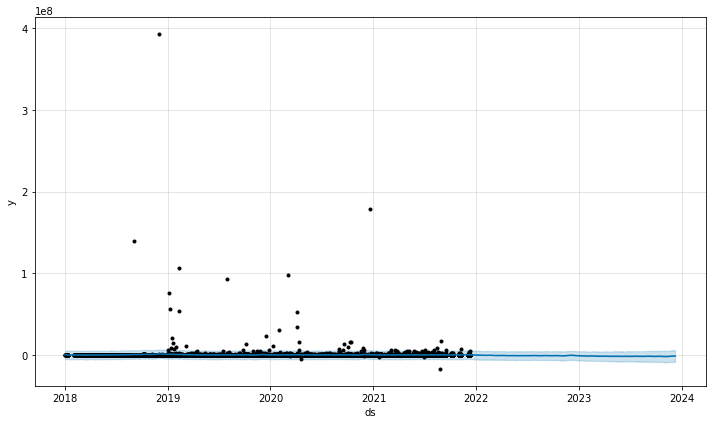

In [122]:
#checking the general pattern of the resulting dataframe with predictions
figure = model.plot(forecast)

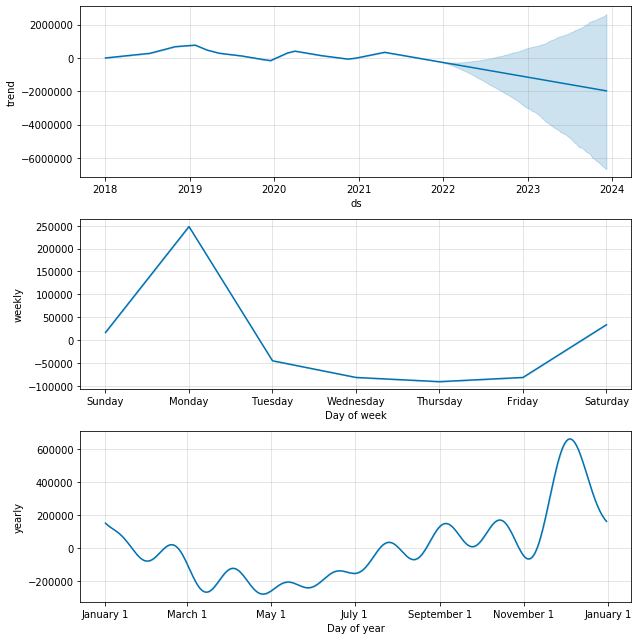

In [123]:
#seeing the result but in components (day, day of week and yearly)

figure_2 = model.plot_components(forecast)

It's also possible to plot this data in diffent dataviz packages, such as Plotly, Seaborn or Matplotlib.